# Лабораторная работа №2
рынок: **Китай** <br>
период: **2018 год**

Седунов Илья, <br>
Альперович Вадим, <br>
Славутин Александр, <br>
17ПМИ.

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
import seaborn as sns
from seaborn import set_style
set_style('dark')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('data/china_stocks.xlsx').drop_duplicates(['Symbol'])
symbols = list(df['Symbol'])
print('China ticker symbols = ', len(symbols))

China ticker symbols =  2500


In [10]:
from IPython.display import clear_output
start = "2018-01-01"
end   = "2018-12-31"
stocks = {}

for symbol in tqdm_notebook(symbols):
    stocks[symbol] = yf.download(symbol, start=start, end=end, progress=False)
clear_output()
print('Акции собраны!')

Акции собраны!


In [22]:
print('Исторические данные для актива', symbols[120])
# stocks[symbols[120]].head()

Исторические данные для актива 300139.SZ


In [12]:
def get_descriptive_statistics(frame):
    E = frame["log_return"].mean()
    sigma = frame["log_return"].std()
    frame['E'] = E
    frame['Sigma'] = sigma
    return frame, E, sigma

def get_return(frame):
    frame['return'] = frame['Close'] / frame['Close'].shift(1)
    frame['log_return'] = np.log(frame['return'])
    return frame

In [14]:
stock_stat = pd.DataFrame(columns=['symbol',  'E', 'Sigma', 'mean_vol', 'mean_return', 'mean_log_return'])

for symbol in tqdm_notebook(symbols):
    stock = get_return(stocks[symbol])
    stock, E, Sigma = get_descriptive_statistics(stock)
    stock_stat.loc[symbol] = [symbol,
                               E,
                               Sigma, 
                               stock['Volume'].mean(), 
                               stock['return'].mean(), 
                               stock['log_return'].mean()]

In [21]:
stock_stat.dropna(inplace=True)
print('Осталось активов после обработки', len(stock_stat))
# stock_stat.head(3)

Осталось активов после обработки 2389


In [900]:
# SSE50 index
sse_components = pd.read_csv('data/SSE50.csv', names=['name', 'industry','symbol'])
sse50 = yf.download('^SSE50', start=start, end=end, progress=False)
sse50 = get_return(sse50)
_, E_sse50, Sigma_sse50 = get_descriptive_statistics(sse50)
# sse50.head(3)

In [87]:
def get_return_mean_cov(df): 
    r_matrix = {}
    for symbol in df['symbol']:
        r_matrix[symbol] = stocks[symbol]['log_return'] 
    r_df = pd.DataFrame(r_matrix)
    return r_df.values, r_df.mean().values, r_df.cov().values

def plot_mean_var_map(df,x='Sigma', y='E', title='Карта активов:σ от E', figsize=(12, 6)):
    ax = df.plot(x=x, y=y, s=np.log(df['mean_vol']**3), 
                          kind='scatter', 
                          figsize=figsize, 
                          edgecolor='black',
                          grid=True)
    plt.xlabel('Sigma', size=15)
    plt.ylabel('E', size=15)
    plt.title(title, size=16)

## 1. Efficient frontier. 
 1. Выбрать на рынке набор из 50 акций. 
 2. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и эффективный фронт с запретом  - коротких позиций. 
 3. Сравнить эффективные фронты и сделать выводы. 
 4. При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем  эффективном фронте. 
 5. Рассмотреть портфель с равными долями вложения капитала и оценить, как далек этот портфель от эффективного фронта. 
 6. Тот же вопрос для индекса рынка.

### 1.1 Выбрать на рынке набор из 50 акций.

In [871]:
stock_stat['sharp'] = stock_stat['E'] / stock_stat['Sigma']
selected50 = stock_stat.sort_values(['sharp'], ascending=False).iloc[:1000].sample(50)
selected50.head()

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,sharp
600028.SS,600028.SS,-0.000960,0.019308,1.549011e+08,0.999226,-0.000960,-0.049697
600461.SS,600461.SS,-0.000652,0.015316,2.791846e+06,0.999465,-0.000652,-0.042568
300253.SZ,300253.SZ,0.002496,0.035459,3.917076e+07,1.003131,0.002496,0.070403
002683.SZ,002683.SZ,0.000428,0.028917,6.327178e+06,1.000845,0.000428,0.014805
603012.SS,603012.SS,0.000299,0.017991,2.740645e+06,1.000459,0.000299,0.016604


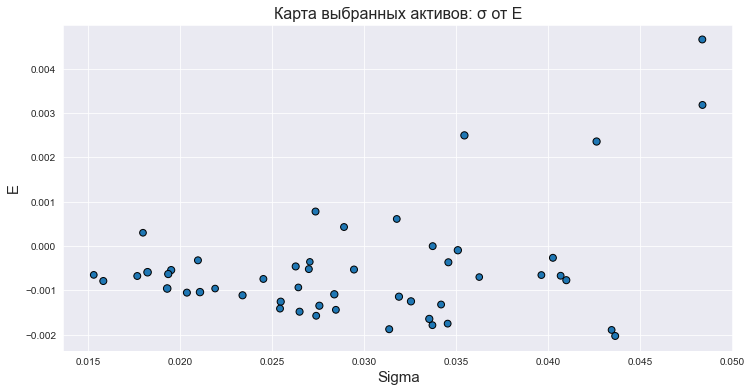

In [872]:
plot_mean_var_map(selected50, title='Карта выбранных активов: σ от E')

### 1.2 Построить эффективный фронт портфелей инвестиций 

In [873]:
from scipy.optimize import minimize

def risk_porfolio(X, cov_matrix):
    return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))

def optimize_portfolio(risk_porfolio,
                       returns, 
                       cov_matrix, 
                       bounds,
                       N, target_return=None):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N

    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    if target_return:
        constraints.append({'type': 'eq', 
                            'args': (returns,), 
                            'fun': lambda X, returns: portfolio_return - np.dot(X, returns)})

    return minimize(risk_porfolio, X,
                    args=(cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x

 - без ограничений на короткие позиции 

$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \end{cases} $$

In [874]:
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected50)

In [887]:
N = 50
psigmas = []
preturns = []
bounds = ((-1, 1),) 



X_min_risk = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N)
min_risk = risk_porfolio(X_min_risk, cov_matrix)
min_risk_preturn = np.dot(X_min_risk, selected50['E'].values)
target_range = np.linspace(min_risk_preturn, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas.append(risk_porfolio(X, cov_matrix))
    preturns.append(np.dot(X, selected50['E'].values))

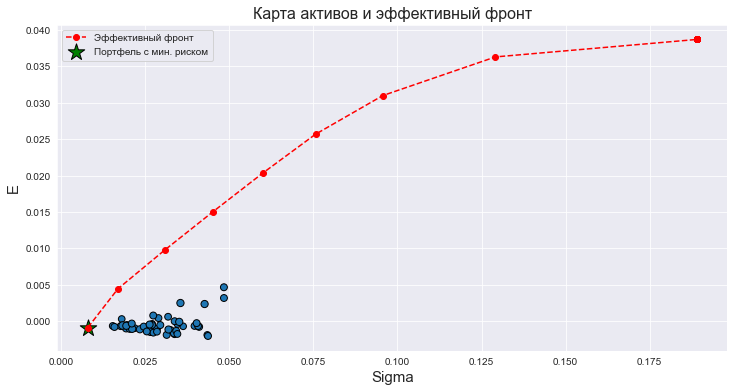

In [892]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.scatter(min_risk, min_risk_preturn, c='green',
            marker='*', s=300, label='Портфель с мин. риском', edgecolors='black',)
plt.plot(psigmas, preturns, 'ro--', label='Эффективный фронт')
plt.legend()
plt.show()

 -  с запретом  - коротких позиций.
$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i\end{cases} $$

In [884]:
N = 50
psigmas_no_short = []
preturns_no_short = []
bounds = ((0.0, 1.1),) 


X_min_risk_ns = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk_ns = risk_porfolio(X_min_risk_ns, cov_matrix)
min_risk_preturn_ns = np.dot(X_min_risk_ns, selected50['E'].values)
target_range = np.linspace(min_risk_preturn_ns, 1, 20)


for portfolio_return in tqdm_notebook(target_range):
    X_no_short = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N, 
                                   target_return=portfolio_return)
    psigmas_no_short.append(risk_porfolio(X_no_short, cov_matrix))
    preturns_no_short.append(np.dot(X_no_short, selected50['E'].values))

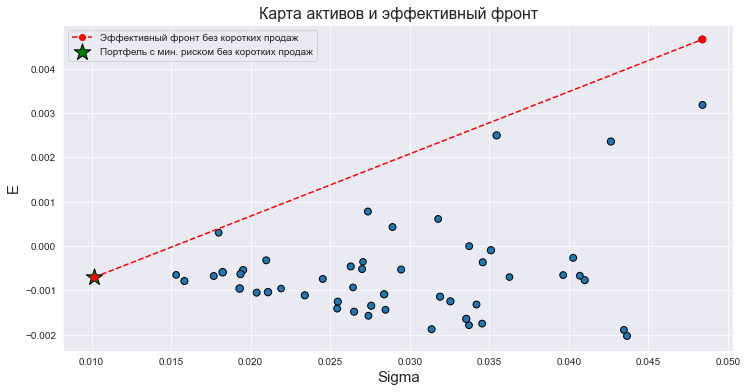

In [891]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'ro--', label='Эффективный фронт без коротких продаж')
plt.scatter(min_risk_ns, min_risk_preturn_ns, c='green',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')
plt.legend()
plt.show()

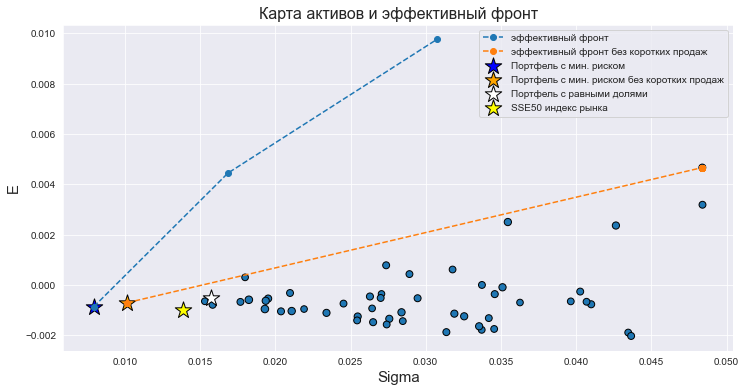

In [905]:
p = 3
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж')

plt.scatter(min_risk, min_risk_preturn, c='blue',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском')

plt.scatter(min_risk_ns, min_risk_preturn_ns, c='orange',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')

risk_pequals = risk_porfolio(np.ones(50) / 50 , cov_matrix ) 
return_pequals = np.dot((np.ones(50) / 50),  selected50['E'].values)
plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')

plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** ...

## 2. Portfolio selection problem. 
Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций) для двух случаев
 - короткие продажи разрешены,
 - короткие продажи запрещены.

In [953]:
# способ 1: генерим много раз подвыборку акций, выбираем с минимальной суммой матрицы ковариации
# samples = {}
# for i in range(1000):
#     sample = selected50.sample(10)
#     r_matrix, mean_vec, cov_matrix = get_return_mean_cov(sample)
#     cov_sum = cov_matrix.sum()
#     samples[cov_sum] = (r_matrix, mean_vec, cov_matrix, sample)
# r_matrix, mean_vec, cov_matrix, selected10 = samples[np.max(list(samples.keys()))]

In [970]:
# способ 2: выбираем 10 самых лучших акций по коэффициенту Шарпа
selected10 = stock_stat.sort_values(['sharp'], ascending=[False]).iloc[:10]
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected10)

In [971]:
# способ 3: выбираем 10 самых лучших акций по риску
# selected10 = stock_stat.sort_values(['Sigma'], ascending=[True]).iloc[:10]
# r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected10)

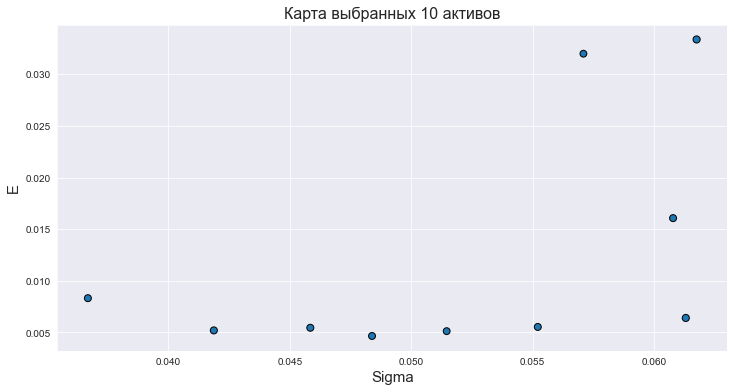

In [977]:
plot_mean_var_map(selected10, title='Карта выбранных 10 активов')

In [973]:
# эффективный фронт 

N = 10
psigmas10 = []
preturns10 = []
bounds = ((-1, 1),) 


X_min_risk10 = optimize_portfolio(risk_porfolio,
                                   selected10['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk10 = risk_porfolio(X_min_risk10, cov_matrix)
min_risk_preturn10 = np.dot(X_min_risk10, selected10['E'].values)
target_range = np.linspace(min_risk_preturn10, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           selected10['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas10.append(risk_porfolio(X, cov_matrix))
    preturns10.append(np.dot(X, selected10['E'].values))

In [974]:
# эффективный фронт без коротких продаж

N = 10
psigmas10_no_short = []
preturns10_no_short = []
bounds = ((0, 1),) 



X_min_risk10 = optimize_portfolio(risk_porfolio,
                                   selected10['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk10 = risk_porfolio(X_min_risk10, cov_matrix)
min_risk_preturn10 = np.dot(X_min_risk10, selected10['E'].values)
target_range = np.linspace(min_risk_preturn10, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X_no_short10 = optimize_portfolio(risk_porfolio,
                           selected10['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas10_no_short.append(risk_porfolio(X_no_short10, cov_matrix))
    preturns10_no_short.append(np.dot(X_no_short10, selected10['E'].values))

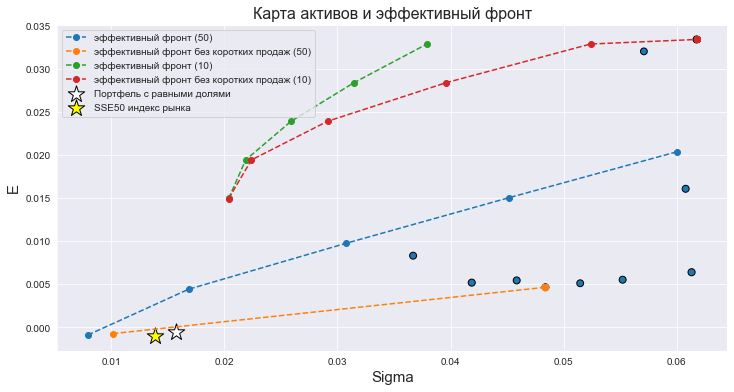

In [976]:
p = 5
plot_mean_var_map(selected10, title='Карта активов и эффективный фронт')


plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт (50)')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж (50)')
plt.plot(psigmas10[:p], preturns10[:p], 'o--', label='эффективный фронт (10)')
plt.plot(psigmas10_no_short, preturns10_no_short, 'o--', label='эффективный фронт без коротких продаж (10)')


plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')

plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** ...

## 3. Risk aversion. 
Оцените свое отношение к риску и постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов. Дайте характеристику портфеля по составу и долям активов. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.

## 4. Risk aversion and Portfolio selection.
Используя выбранное в п.3 отношение к риску постройте оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей портфеля. Рассмотрите два случая:

  - короткие продажи разрешены,
  - короткие продажи запрещены.

## 5. Markowitz-Tobin model. 
Рассмотрите набор активов, отобранных в п.2 (10 активов). Выберете безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный) портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.


## 6. Бонус. Индекс рынка.

Разберитесь, как составляется портфель индекса (определите веса, с которыми активы входят в индекс). Дайте характеристику индекса (гистограмма, распределение, выбросы). На основе метода главных компонент предложите свою модель индекса рынка. Сравните ваш индекс с индексом рынка.